# (1) Bài toán

Nhận dạng bình luận độc hại (toxic comment classification). Bình luận độc hại là những bình luận chửi tục, phân biệt đối xử, ....  
Đầu vào là một bình luận đầu ra sẽ là một nhãn 0 hoặc 1 với 1 là comment toxic và 0 là bình thường.

# (2) EDA

In [1]:
import pandas as pd
from seaborn import countplot

In [2]:
raw_data = pd.read_csv("data/raw_data.csv")
raw_data.tail()

,id,comment,is_toxic
12671,12671,Bảo Bảo hum đúng là như lozz thật xem clip tắt...,1
12672,12672,Trần Hà hên là mày khôn ra,0
12673,12673,Bích Huyền chuyện dì cũng có thể xảy ra,0
12674,12674,Nguyễn Trân Trân dm t nhìn giống m vl :)),1
12675,12675,Nguyễn Trang mới đọc nãy,0


Dữ liệu thu được gồm 12675 bình luận. Gồm các trường id, comment, is_toxic.

In [3]:
ex = [raw_data.loc[98].comment, raw_data.loc[108].comment, raw_data.loc[1964].comment]
print(ex)

['Việt Trinh', 'Hương Gà k ck mình hơn mình 5t. Mệt lắm =)))))', '👉Nhận order mua hộ vận chuyện hàng Trung - Việt 😊\n👉 Hàng nội địa giá tận gốc.\n👉Chuyên sỉ (hàng có sẵn)\n\n😘Like Trang https://m.facebook.com/101837188158750/photos/a.101838121491990/103918364617299/?type=3&source=44 để cập nhật những món khoái khẩu nhé 🥰']


Dữ liệu comment có chứa tên riêng, từ viết tắt, emoji, url, sai chính tả, thiếu dấu, teencode.

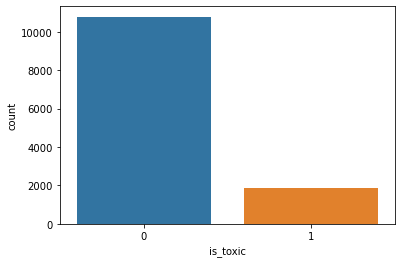

In [4]:
countplot(raw_data.is_toxic)

In [5]:
num_0, num_1 = raw_data.is_toxic.value_counts().values
print(f"Các bình luận độc hại chiếm {round(num_1 / (num_0 + num_1) * 100, 2)}% tổng số bình luận.")

Các bình luận độc hại chiếm 14.9% tổng số bình luận.


## Word cloud

Word cloud sau khi đã qua tiền xử lý.

![Clean cloud](cloud/clean_cloud.png)
![Toxic cloud](cloud/toxic_cloud.png)

# (3) Modeling

## Chia dữ liệu

Chia dữ liệu ra làm 3 bộ train/valid/test theo tỉ lệ 6/2/2.  
Đầu tiên chia train (80%) và test (20%) theo bộ dữ liệu đầy đủ. Sau đó chia valid 25% từ bộ train.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = raw_data.drop(["is_toxic", "id"], axis=1)
y = raw_data.is_toxic

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=41, stratify=y_train)

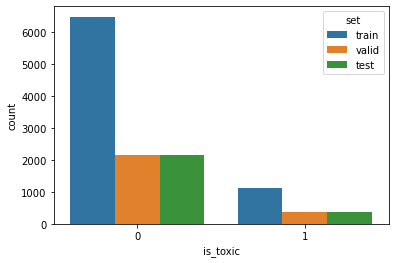

In [9]:
dftr = pd.DataFrame(data={"is_toxic": y_train, "set": ["train"] * len(y_train)})
dfva = pd.DataFrame(data={"is_toxic": y_valid, "set": ["valid"] * len(y_valid)})
dfte = pd.DataFrame(data={"is_toxic": y_test, "set": ["test"] * len(y_test)})
frame = [dftr, dfva, dfte]
ess = pd.concat(frame)
countplot(data=ess, hue="set", x="is_toxic")

## Tiền xử lý

Tiền xử lý bao gồm các việc:
* Bỏ khoảng trắng thừa, tên riêng, số, chữ dài hơn chữ "nghiêng", url, ký tự đặc biệt, stop word
* Rút gọn các chữ lặp lại VD: haizzzzzz -> haiz
* Tokenize VD: học sinh -> học_sinh

In [10]:
from preproc.preprocess import preproc

In [11]:
X_train_cooked = preproc(X_train)
X_valid_cooked = preproc(X_valid)
X_test_cooked = preproc(X_test)

## Tf-idf

Term frequency inverse document frequency được tính bằng công thức:  
$tf-idf(t, d) = tf(t, d) * idf(t)$

*t là chữ và d là bình luận.*

Theo sklearn **tf(t, d)** được tính bằng **CountVectorizer**. 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [13]:
corpus = ["tôi đi học", "tôi đi chơi"]
exvec = CountVectorizer()
exvec.fit(corpus)
exvec.get_feature_names()

['chơi', 'học', 'tôi', 'đi']

In [14]:
ex = exvec.transform(corpus).toarray()
ex

array([[0, 1, 1, 1],
       [1, 0, 1, 1]])

**smooth_idf=False**  
$ idf(t) = log(\frac{n}{df(t)}) + 1 $

**smooth_idf=True**  
$ idf(t) = log(\frac{n + 1}{df(t) + 1}) + 1 $


*n là tổng số lượng các bình luận*  
*df(t) là số bình luận trong đó có chứa t*

In [15]:
transformer = TfidfTransformer()
transformer.fit(ex)
transformer.idf_

array([1.40546511, 1.40546511, 1.        , 1.        ])

$tf-idf(\text{"tôi đi học"}) = [0 * 1.41,  1 * 1.41,  1 * 1,  1 * 1] = [0. ,  1.41,  1,  1]$

Thư viện sklearn sau đó thực hiện **normalization** trên vector tf-idf bằng công thức:  
$v_{norm} = \frac{v}{\sqrt(v_{1}^{2} + v_{2}^{2} + ... + v_{n}^{2})} = [0., 0.7, 0.5, 0.5]$

In [16]:
transformer.transform(ex).toarray()

array([[0.        , 0.70490949, 0.50154891, 0.50154891],
       [0.70490949, 0.        , 0.50154891, 0.50154891]])

## Thực hiện chuyển đổi sang tf-idf

Trong sklearn có TfidfVectorizer tương đương với việc thực hiện CountVectorizer sau đó TfidfTransformer.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
corpus = X_train_cooked.comment.values
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=7000)
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=7000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [19]:
X_train_vec = vectorizer.transform(corpus).toarray()
X_valid_vec = vectorizer.transform(X_valid_cooked.comment.values).toarray()
X_test_vec = vectorizer.transform(X_test_cooked.comment.values).toarray()
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lg = LogisticRegression(solver="liblinear")
lg.fit(X_train_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [23]:
y_train_pred = lg.predict(X_train_vec)
y_valid_pred = lg.predict(X_valid_vec)
y_test_pred = lg.predict(X_test_vec)

In [24]:
print(f"Train f1: {f1_score(y_train, y_train_pred)}")
print(f"Train precision: {precision_score(y_train, y_train_pred)}")
print(f"Train recall: {recall_score(y_train, y_train_pred)}")
print(f"\nValid f1: {f1_score(y_valid, y_valid_pred)}")
print(f"Valid precision: {precision_score(y_valid, y_valid_pred)}")
print(f"Valid recall: {recall_score(y_valid, y_valid_pred)}")
print(f"\nTest f1: {f1_score(y_test, y_test_pred)}")
print(f"Test precision: {precision_score(y_test, y_test_pred)}")
print(f"Test recall: {recall_score(y_test, y_test_pred)}")

Train f1: 0.7367256637168142
Train precision: 0.9866666666666667
Train recall: 0.587819947043248

Valid f1: 0.6825127334465195
Valid precision: 0.95260663507109
Valid recall: 0.5317460317460317

Test f1: 0.7015177065767284
Test precision: 0.9674418604651163
Test recall: 0.5502645502645502


## Regularization

$J(\theta)=−\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(h_{\theta}(x^{(i)})) + (1 - y^{(i)})log(1 - h_{\theta}(x^{(i)}))]$

### L1 regularization

$J(\theta)=−\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(h_{\theta}(x^{(i)})) + (1 - y^{(i)})log(1 - h_{\theta}(x^{(i)}))] + \lambda\sum_{j=1}^{n}|\theta_{j}|$

Loại bỏ các feature không quan trọng bằng cách cho $\theta$ tương ứng về 0.

In [25]:
import matplotlib.pyplot as plt

In [26]:
c_list = [0.12, 0.24, 0.48, 1.62, 2.88, 5.2, 10.12]
f1_train = []
f1_valid = []
f1_test = []
for i in c_list:
    lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=i,
                        penalty="l1",
                        max_iter=1000)
    lg.fit(X_train_vec, y_train)
    y_train_pred = lg.predict(X_train_vec)
    y_valid_pred = lg.predict(X_valid_vec)
    y_test_pred = lg.predict(X_test_vec)
    f1_train.append(f1_score(y_train, y_train_pred))
    f1_valid.append(f1_score(y_valid, y_valid_pred))
    f1_test.append(f1_score(y_test, y_test_pred))

/home/miu/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'f1-score')

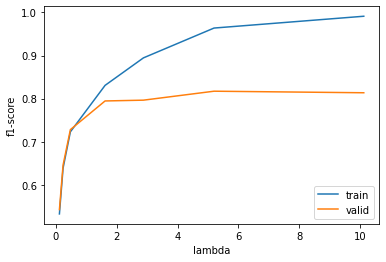

In [27]:
plt.plot(c_list, f1_train, label="train")
plt.plot(c_list, f1_valid, label="valid")
plt.legend(loc="lower right")
plt.xlabel("lambda")
plt.ylabel("f1-score")

### L2 regularization

$J(\theta)=−\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(h_{\theta}(x^{(i)})) + (1 - y^{(i)})log(1 - h_{\theta}(x^{(i)}))] + \lambda\sum_{j=1}^{n}\theta_{j}^{2}$

Giảm $\theta$ của các feature không quan trọng về con số rất nhỏ.

In [28]:
c_list = [0.12, 0.24, 0.48, 1.62, 2.88, 5.2, 10.12]
f1_train = []
f1_valid = []
f1_test = []
for i in c_list:
    lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=i,
                        penalty="l2",
                        max_iter=1000)
    lg.fit(X_train_vec, y_train)
    y_train_pred = lg.predict(X_train_vec)
    y_valid_pred = lg.predict(X_valid_vec)
    y_test_pred = lg.predict(X_test_vec)
    f1_train.append(f1_score(y_train, y_train_pred))
    f1_valid.append(f1_score(y_valid, y_valid_pred))
    f1_test.append(f1_score(y_test, y_test_pred))

Text(0, 0.5, 'f1-score')

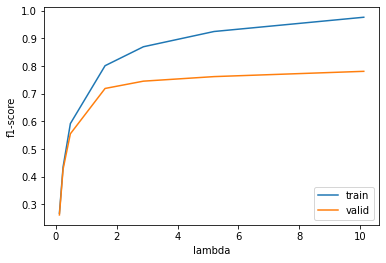

In [29]:
plt.plot(c_list, f1_train, label="train")
plt.plot(c_list, f1_valid, label="valid")
plt.legend(loc="lower right")
plt.xlabel("lambda")
plt.ylabel("f1-score")

Cả hai phương pháp tốt nhất khi $\lambda \approx 1.8$ nhưng f1-score của L1 tốt hơn L2.

In [30]:
lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=1.8,
                        penalty="l1",
                        max_iter=1000)
lg.fit(X_train_vec, y_train)

LogisticRegression(C=1.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=41, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
y_train_pred = lg.predict(X_train_vec)
y_valid_pred = lg.predict(X_valid_vec)
y_test_pred = lg.predict(X_test_vec)

In [32]:
print(f"Train f1: {f1_score(y_train, y_train_pred)}")
print(f"Train precision: {precision_score(y_train, y_train_pred)}")
print(f"Train recall: {recall_score(y_train, y_train_pred)}")
print(f"\nValid f1: {f1_score(y_valid, y_valid_pred)}")
print(f"Valid precision: {precision_score(y_valid, y_valid_pred)}")
print(f"Valid recall: {recall_score(y_valid, y_valid_pred)}")
print(f"\nTest f1: {f1_score(y_test, y_test_pred)}")
print(f"Test precision: {precision_score(y_test, y_test_pred)}")
print(f"Test recall: {recall_score(y_test, y_test_pred)}")

Train f1: 0.8443142996583699
Train precision: 0.9443231441048034
Train recall: 0.7634598411297441

Valid f1: 0.7886904761904762
Valid precision: 0.9013605442176871
Valid recall: 0.701058201058201

Test f1: 0.808080808080808
Test precision: 0.8888888888888888
Test recall: 0.7407407407407407


# (4) Error analysis

In [33]:
confusion_matrix = pd.crosstab(y_valid_pred, y_valid, rownames=['Predicted'], colnames=['Actual'])
print(confusion_matrix)

Actual        0    1
Predicted           
0          2128  113
1            29  265


In [34]:
wrong_valid = []
for index, label in enumerate(y_valid_pred):
    if label == 0 and y_valid[index] == 1:
        wrong_valid.append(X_valid.comment.values[index])
print(f"Trong tập valid có {len(wrong_valid)} câu dự đoán sai ra 0 nhưng thật là 1.")

Trong tập valid có 113 câu dự đoán sai ra 0 nhưng thật là 1.


In [35]:
from preproc.preprocess import new_preproc
import numpy as np

In [36]:
new_df = pd.DataFrame({"comment": wrong_valid})
new_y = np.zeros(len(wrong_valid)) + 1
new_cooked_valid = new_preproc(new_df)
new_vec = vectorizer.transform(new_cooked_valid.comment.values).toarray()
new_y_pred = lg.predict(new_vec)
correct = []
for index, label in enumerate(new_y):
    if new_y[index] == new_y_pred[index]:
        correct.append(wrong_valid[index])

correct_df = pd.DataFrame({"comment": correct})
old_cooked = preproc(correct_df)
new_cooked = new_preproc(correct_df)

for index, comment in enumerate(correct_df.comment.values):
    print(f"[RAW] {correct[index]}")
    print(f"[OLD] {old_cooked.comment.values[index]}")
    print(f"[NEW] {new_cooked.comment.values[index]}\n")

[RAW] Ngu thì chết. Bệnh tật j
[OLD] chết bệnh_tật
[NEW] ngu chết bệnh_tật

[RAW] Đéo thấy zui chỗ nào
[OLD] thấy zui chỗ nào
[NEW] đéo thấy zui chỗ nào

[RAW] Đéo hiểu dơ tay
[OLD] hiểu dơ tay
[NEW] đéo hiểu dơ tay

[RAW] Loại giết người hàng loạt như thế này thì sử bắn luôn thôi,đúng là bọn khốn nạn sợ quá
[OLD] giết người hàng_loạt thế thì sử bắn luôn bọn khốn_nạn sợ quá
[NEW] loại giết người hàng_loạt thế thì sử bắn luôn bọn khốn_nạn sợ quá

[RAW] Ngu hết sức
[OLD] hết_sức
[NEW] ngu hết_sức

[RAW] Nó nói đúng chứ sai chỗ đéo nào? Đá thì bạo lực, trọng tài thì mù lòa, sân thì như cái ruộng Đưa vào hư mẹ nó hết hình Bọn tỏ ra yêu nước hay xạo xạo ra vẻ lắm Có xài bphone chạy xe vin k vậy mấy th yêu nước?
[OLD] nó nói đúng sai chỗ đéo nào bạo_lực trọng_tài mù_lòa sân như ruộng đưa hư mẹ nó hết hình tỏ yêu nước hay xạo xạo ra_vẻ lắm xài bphone chạy xe vin vậy mấy thằng yêu nước
[NEW] nó nói đúng sai chỗ đéo nào đá bạo_lực trọng_tài mù_lòa sân như ruộng đưa hư mẹ nó hết hình bọn tỏ yêu 

Một số câu bị mất từ do phần xử lý bỏ tên riêng của underthesea chưa chính xác làm thay đổi ý nghĩa câu.

In [37]:
new_X_valid_cooked = new_preproc(X_valid)
new_X_test_cooked = new_preproc(X_test)
new_valid_vec = vectorizer.transform(new_X_valid_cooked.comment.values).toarray()
new_test_vec = vectorizer.transform(new_X_test_cooked.comment.values).toarray()
new_valid_pred = lg.predict(new_valid_vec)
new_test_pred = lg.predict(new_test_vec)
print(f"Valid f1: {f1_score(y_valid, new_valid_pred)}")
print(f"Valid precision: {precision_score(y_valid, new_valid_pred)}")
print(f"Valid recall: {recall_score(y_valid, new_valid_pred)}")
print(f"\nTest f1: {f1_score(y_test, new_test_pred)}")
print(f"Test precision: {precision_score(y_test, new_test_pred)}")
print(f"Test recall: {recall_score(y_test, new_test_pred)}")

Valid f1: 0.8011695906432749
Valid precision: 0.8954248366013072
Valid recall: 0.7248677248677249

Test f1: 0.8028571428571427
Test precision: 0.8726708074534162
Test recall: 0.7433862433862434


In [38]:
confusion_matrix = pd.crosstab(new_valid_pred, y_valid, rownames=['Predicted'], colnames=['Actual'])
print(confusion_matrix)

Actual        0    1
Predicted           
0          2125  104
1            32  274


Sau khi bỏ xử lý tên riêng tập valid tăng 1%.

## Thiếu dữ liệu?

In [39]:
from misc import get_learning_curve

In [40]:
cooked_data = pd.read_csv("data/cooked_data.csv", na_filter=False)
frac_list = [500, 1000, 2500, 3000, 4500, 5500, 6450, 7000, 8500, 10500, 11500, 12000]
sub_f1_train, sub_f1_valid, sub_f1_test = get_learning_curve(frac_list, cooked_data)

Text(0, 0.5, 'f1-score')

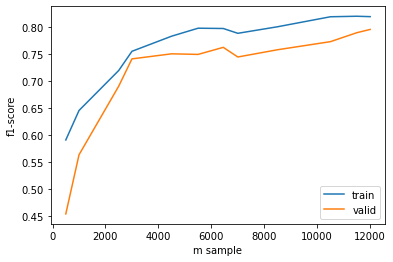

In [41]:
plt.plot(frac_list, sub_f1_train, label="train")
plt.plot(frac_list, sub_f1_valid, label="valid")
plt.legend(loc="lower right")
plt.xlabel("m sample")
plt.ylabel("f1-score")

Càng nhiều sample f1-score có xu hướng tăng dần.

# (5) Model interpretation

In [42]:
sum = 0
for coef in lg.coef_[0]:
    if coef != 0:
        sum += 1
print(f"l1 giảm số feature từ {len(lg.coef_[0])} còn {sum}")

l1 giảm số feature từ 7000 còn 286


$\text{odds} = \frac{P(y=1)}{P(y=0)} = exp(\sum_{i=0}^{n}\theta_{i}x_{i})$

Odds cho biết khả năng của một bình luận thuộc về lớp 1 cao hơn bao nhiêu lần so với lớp 0.

In [43]:
test_corp = {"comment": ["tôi đi học", "mấy con chó này", "đừng ăn thịt chó nữa"]}
test_df = pd.DataFrame(test_corp)
test_df = preproc(test_df)
test_df_vec = vectorizer.transform(test_df.comment.values)

p = lg.predict_proba(test_df_vec)
odds = p[:, 1] / p[:, 0]
odds

array([0.03602253, 2.21667224, 0.07972213])

"tôi đi học" có khả năng thuộc về lớp 1 chỉ bằng khoảng 0.03 lần so với lớp 0  
"mấy con chó này" có khả năng thuộc về lớp 1 hơn 2 lần so với lớp 0  
"đừng ăn thịt chó nữa" có khả năng thuộc về lớp 1 chỉ bằng khoảng 0.08 lần so với lớp 0

  $\text{odds_ratio} = \frac{odds_{x_{i}+1}}{odds} = exp(\theta_{j})$

**odds_ratio** của feature $x_{j}$ cho biết khả năng của bình luận thuộc về lớp 1 tăng thêm bao nhiêu nếu nó tăng thêm 1.

In [44]:
import numpy as np

dic = {"word": vectorizer.get_feature_names(),
       "weight": lg.coef_[0],
       "odds_ratio": np.exp(lg.coef_[0])}
table = pd.DataFrame(dic)

In [45]:
table.sort_values(by=["odds_ratio"], axis=0, ascending=False).head(10)

,word,weight,odds_ratio
2989,lồn,35.275082,2.088206e+15
6702,đéo,20.325032,6.715051e+08
1505,cặc,16.219455,1.106675e+07
69,ba_que,14.034756,1.245137e+06
6870,địt_mẹ,13.907415,1.096260e+06
1059,con_mẹ,12.747482,3.436854e+05
133,buồi,11.352941,8.521569e+04
4760,súc_vật,9.896315,1.985706e+04
3596,ngu,9.840463,1.877841e+04
6864,địt,8.967095,7.840790e+03


In [46]:
table.sort_values(by=["odds_ratio"], axis=0, ascending=True).head()

,word,weight,odds_ratio
218,bạn,-4.832295,0.007968
6976,ấy,-4.759211,0.008572
1786,em,-3.278977,0.037667
356,bọn nó,-3.064833,0.046662
30,anh,-2.456212,0.085759


Ta thấy các từ chửi tục có odds_ratio rất cao nên có thể kết luận model đang làm đúng việc.